In [ ]:
#buat dummy file

import numpy as np
import pandas as pd
np.random.seed(42)

n_A = 80000
n_B = 80000
p_A = 0.02
p_B = 0.024  # 20% relative uplift

conv_A = np.random.binomial(1, p_A, n_A)
conv_B = np.random.binomial(1, p_B, n_B)

df_A = pd.DataFrame({
    'variant': 'A',
    'user_id': np.arange(n_A),
    'converted': conv_A
})

df_B = pd.DataFrame({
    'variant': 'B',
    'user_id': np.arange(n_A, n_A + n_B),
    'converted': conv_B
})

df = pd.concat([df_A, df_B], ignore_index=True)

# Tambahan kolom waktu dan kontaminan sederhana
import datetime
start = datetime.datetime(2025,7,1)
df['timestamp'] = [start + datetime.timedelta(seconds=int(x)) for x in np.random.randint(0, 14*24*3600, len(df))]

# Simpan
# 

In [2]:
df.to_csv('ab_test_simulated.csv', index=False)

In [3]:
df.head()

,variant,user_id,converted,timestamp
0,A,0,0,2025-07-14 19:56:19
1,A,1,0,2025-07-01 06:44:54
2,A,2,0,2025-07-11 12:10:04
3,A,3,0,2025-07-10 21:15:32
4,A,4,0,2025-07-10 15:45:46


In [7]:
# Analisis sederhana
import statsmodels.api as sm
from statsmodels.stats.proportion import proportions_ztest

counts = np.array([df[df.variant=='B'].converted.sum(), df[df.variant=='A'].converted.sum()])
ns = np.array([df[df.variant=='B'].shape[0], df[df.variant=='A'].shape[0]])

# biasanya order: count, nobs
stat, pval_two_sided = proportions_ztest(counts, ns)
# convert to one-sided if direction positive (B > A)
if stat > 0:
    pval_one_sided = pval_two_sided / 2
else:
    pval_one_sided = 1 - pval_two_sided / 2

stat, pval_one_sided

(np.float64(6.192152101267748), np.float64(2.967411939050872e-10))

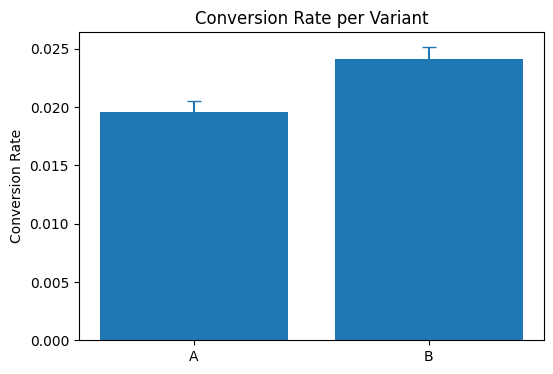

In [5]:
import matplotlib.pyplot as plt
import scipy.stats as st

# CR per variant
agg = df.groupby('variant').converted.agg(['mean','count'])
agg['se'] = np.sqrt(agg['mean']*(1-agg['mean'])/agg['count'])
agg['ci95'] = st.norm.ppf(0.975)*agg['se']

plt.figure(figsize=(6,4))
plt.bar(agg.index, agg['mean'])
plt.errorbar(agg.index, agg['mean'], yerr=agg['ci95'], fmt='none', capsize=5)
plt.ylabel('Conversion Rate')
plt.title('Conversion Rate per Variant')
plt.show()